In [1]:
%load_ext autoreload
%autoreload 2
import sys

# insert at 1, 0 is the script path (or ‘’ in REPL)
sys.path.insert(1, '../')

import numpy as np
import torch
from torch.utils.data import DataLoader
from bayesian_neural_net import CLSTM_cell
from bayesian_neural_net import ConvCell
from bayesian_neural_net import Encoder
from bayesian_neural_net import Decoder
from bayesian_neural_net import ED
from visualization import plot_spatio_temporal_data
from simulation_dataset import MovingMNIST
from simulation_dataset_datamodule import DatasetDataModule
from trainer import LightningED
from visualization import plot_spatio_temporal_data
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

# set the seed globally for reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
root = '../../data'
n_frames_input = 10
n_frames_output = 10
num_digits = 2
image_size = 64
digit_size = 28
N = 2000  # total number of samples including training and validation data

data = MovingMNIST(root, n_frames_input, n_frames_output, num_digits, image_size, digit_size, N, use_fixed_dataset=True)

data_module = DatasetDataModule(data, 1, 0.5)

# build the model
rnns = [CLSTM_cell(shape=(64, 64), input_channels=1, filter_size=5, num_features=64, dropout_rate=0.1), CLSTM_cell(shape=(64, 64), input_channels=64, filter_size=3, num_features=64, dropout_rate=0.1)]
encoder_net = Encoder(rnns)
rnns = [CLSTM_cell(shape=(64, 64), input_channels=1, filter_size=5, num_features=64, dropout_rate=0.1), CLSTM_cell(shape=(64, 64), input_channels=64, filter_size=3, num_features=64, dropout_rate=0.1)]
cnn = ConvCell(in_channels=128, out_channels=1, kernel_size=1, stride=1, padding=0)
decoder_net = Decoder(rnns, cnn)
ED_net = ED(encoder_net, decoder_net)
mc_dropout = 5
learning_rate = 1e-4
max_epoch = 20
model = LightningED(ED_net, mc_dropout, learning_rate)



# load from checkpoint
try:
    model.load_from_checkpoint(checkpoint_path='moving_mnist.ckpt', ED=ED_net, mc_dropout=mc_dropout, learning_rate=learning_rate)
except:
    pass



#logger = TensorBoardLogger('tb_logs', name='Bayesian_ConvLSTM')

if torch.cuda.is_available():
    trainer = pl.Trainer(max_epochs=max_epoch, gpus=1)
else:
    trainer = pl.Trainer(max_epochs=max_epoch)         
trainer.fit(model, data_module)



# save the checkpoint
trainer.save_checkpoint("moving_mnist.ckpt")


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


GroupNorm will be applied!
GroupNorm will be applied!
GroupNorm will be applied!
GroupNorm will be applied!



  | Name          | Type    | Params
------------------------------------------
0 | ED            | ED      | 1.4 M 
1 | loss_function | MSELoss | 0     
------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.700     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training: 0it [00:00, ?it/s]

GroupNorm will be applied!
GroupNorm will be applied!
GroupNorm will be applied!
GroupNorm will be applied!


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


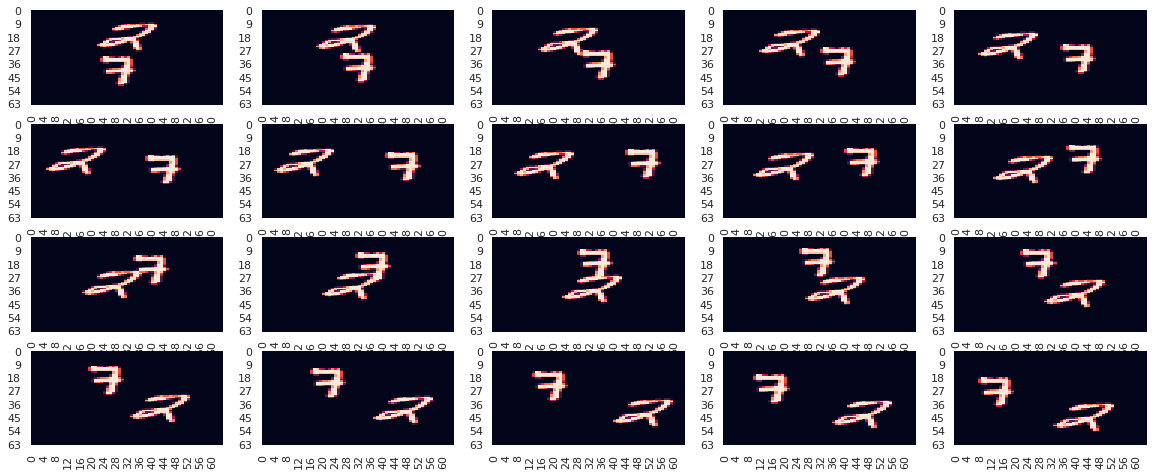

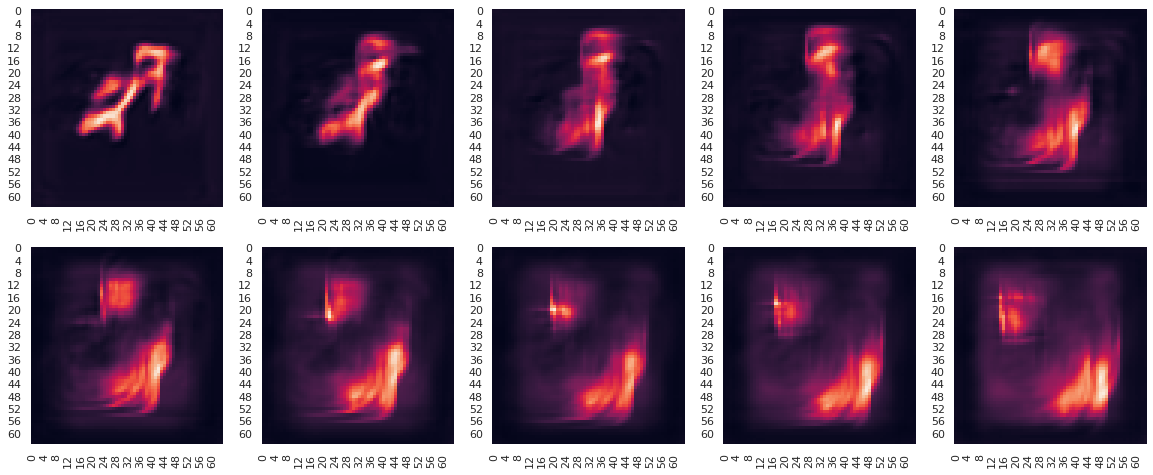

error for the new sample is 0.0298


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
root = '../../data'
n_frames_input = 10
n_frames_output = 10
num_digits = 2
image_size = 64
digit_size = 28
N = 1  # total number of samples including training and validation data

test_data = MovingMNIST(root, n_frames_input, n_frames_output, num_digits, image_size, digit_size, N, use_fixed_dataset=True)

test_data_loader = DataLoader(test_data, 1)

# build the model
rnns = [CLSTM_cell(shape=(64, 64), input_channels=1, filter_size=5, num_features=64, dropout_rate=0), CLSTM_cell(shape=(64, 64), input_channels=64, filter_size=3, num_features=64, dropout_rate=0)]
encoder_net = Encoder(rnns)
rnns = [CLSTM_cell(shape=(64, 64), input_channels=1, filter_size=5, num_features=64, dropout_rate=0), CLSTM_cell(shape=(64, 64), input_channels=64, filter_size=3, num_features=64, dropout_rate=0)]
cnn = ConvCell(in_channels=128, out_channels=1, kernel_size=1, stride=1, padding=0)
decoder_net = Decoder(rnns, cnn)
ED_net = ED(encoder_net, decoder_net)
mc_dropout = 10
learning_rate = 1e-4
max_epoch = 20
model = LightningED(ED_net, mc_dropout, learning_rate)



# load from checkpoint
model.load_from_checkpoint(checkpoint_path='moving_mnist.ckpt', ED=ED_net, mc_dropout=mc_dropout, learning_rate=learning_rate)

model.to(device)  # transfer the model to gpu

# predict for one sample
for idx, batch in enumerate(test_data_loader):

    idx, input_for_encoder, input_for_decoder, additional_time_invariant_input, true_output, seq_len = batch
    
    true_data = torch.cat((input_for_encoder[0], true_output[0]), 1)
    true_data = true_data.squeeze()



    input_for_encoder = [i.to(device) for i in input_for_encoder]
    if len(input_for_decoder) != 0:
        input_for_decoder = [i.to(device) for i in input_for_decoder]
    if len(additional_time_invariant_input) != 0:
        additional_time_invariant_input = [i.to(device) for i in additional_time_invariant_input]


    output = model(input_for_encoder, input_for_decoder, additional_time_invariant_input, seq_len)
    
    if idx == 0:
        break
        

# transfer the tensor on gpu on cpu
predicted_data = torch.cat(output, dim=1).cpu().detach().numpy().squeeze(0).squeeze(1)
true_data = true_data.cpu().detach().numpy()

# plot the true data
plot_spatio_temporal_data(true_data)
plot_spatio_temporal_data(predicted_data)


print("error for the new sample is %.4f"%np.mean((predicted_data - true_data[10:, ...])**2))